In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
from scipy import signal
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from matplotlib.ticker import FormatStrFormatter

## センサデータの取得

In [42]:
acc_file_path = "../../../data/speed/fastWalk/Accelerometer.csv"
gyro_file_path = "../../../data/speed/fastWalk/Gyroscope.csv"

# 通信してデータを取得
df_acc = pd.read_csv(acc_file_path)
df_gyro = pd.read_csv(gyro_file_path)

# センサデータの加工

## ウィンドウの宣言

In [43]:
window_acc = 100
window_pre = 240
window_gyro = 700
shift_amount = window_pre * -1

## 生データの描画

<Figure size 640x480 with 0 Axes>

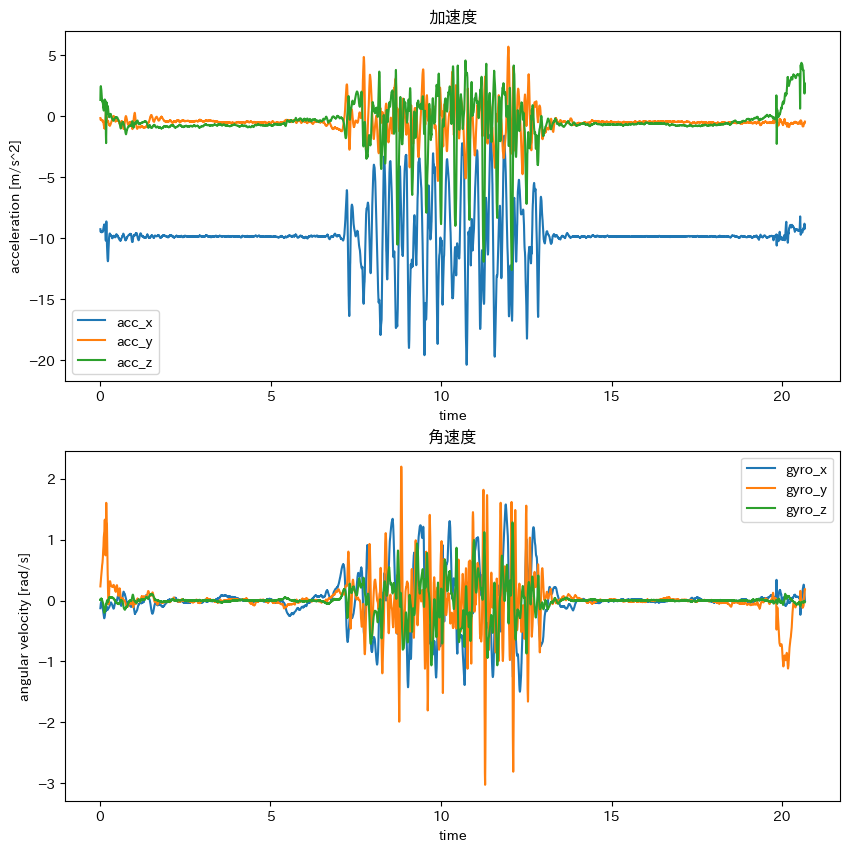

In [44]:
plt.subplots_adjust(hspace=0.3)
fig = plt.figure(figsize=(10, 10))

# 加速度のプロット
ax1 = fig.add_subplot(2,1,1)
ax1.title.set_text("加速度")
ax1.plot(df_acc["t"], df_acc["x"], label="acc_x")
ax1.plot(df_acc["t"], df_acc["y"], label="acc_y")
ax1.plot(df_acc["t"], df_acc["z"], label="acc_z")
ax1.set_xlabel("time")
ax1.set_ylabel("acceleration [m/s^2]")
ax1.legend()

# ジャイロのプロット
ax2 = fig.add_subplot(2,1,2)
ax2.title.set_text("角速度")
ax2.plot(df_gyro["t"], df_gyro["x"], label="gyro_x")
ax2.plot(df_gyro["t"], df_gyro["y"], label="gyro_y")
ax2.plot(df_gyro["t"], df_gyro["z"], label="gyro_z")
ax2.set_xlabel("time")
ax2.set_ylabel("angular velocity [rad/s]")
##ax2.set_xlim(0, 100)
# ax2.set_ylim(-10, 50)
ax2.legend()

plt.show()

## 余分な時間のデータを消す

In [45]:
# # 6 ~ 13sのデータを抽出
df_acc = df_acc[(df_acc['t'] >= 6) & (df_acc['t'] <= 13)]
df_gyro = df_gyro[(df_gyro['t'] >= 6) & (df_gyro['t'] <= 13)]

# # index をリセット
df_acc = df_acc.reset_index(drop=True)
df_gyro = df_gyro.reset_index(drop=True)

## 整形したデータの描画

<Figure size 640x480 with 0 Axes>

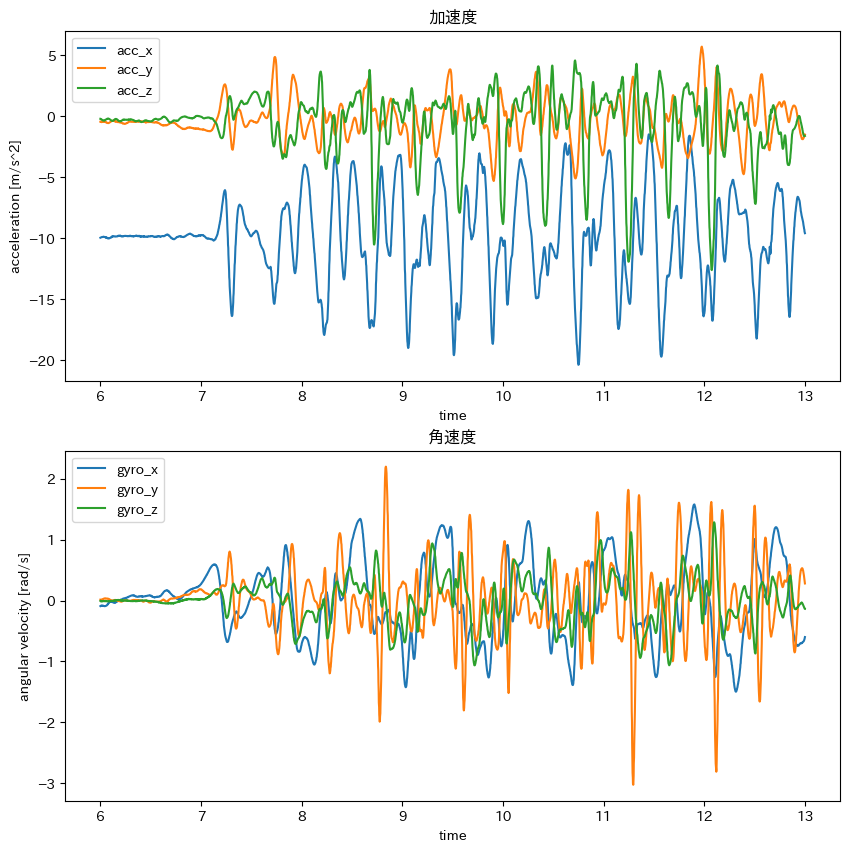

In [46]:
plt.subplots_adjust(hspace=0.3)
fig = plt.figure(figsize=(10, 10))

# 加速度のプロット
ax1 = fig.add_subplot(2,1,1)
ax1.title.set_text('加速度')
ax1.plot(df_acc["t"], df_acc["x"], label="acc_x")
ax1.plot(df_acc["t"], df_acc["y"], label="acc_y")
ax1.plot(df_acc["t"], df_acc["z"], label="acc_z")
ax1.set_xlabel("time")
ax1.set_ylabel("acceleration [m/s^2]")
# ax1.set_xlim(20, 90)
# ax1.set_ylim(-10, 20)
ax1.legend()

# ジャイロのプロット
ax2 = fig.add_subplot(2,1,2)
ax2.title.set_text('角速度')
ax2.plot(df_gyro["t"], df_gyro["x"], label="gyro_x")
ax2.plot(df_gyro["t"], df_gyro["y"], label="gyro_y")
ax2.plot(df_gyro["t"], df_gyro["z"], label="gyro_z")
ax2.set_xlabel("time")
ax2.set_ylabel("angular velocity [rad/s]")
# ax1.set_xlim(20, 90)
# ax2.set_ylim(-10, 20)
ax2.legend()

plt.show()

## ノルムの算出,移動平均フィルター

In [47]:
df_acc['norm'] = (df_acc['x']**2 + df_acc['y']**2 + df_acc['z']**2)**(1/2)
df_gyro['norm'] = (df_gyro['x']**2 + df_gyro['y']**2 + df_gyro['z']**2)**(1/2)

df_gyro['angle'] = np.cumsum(df_gyro['x']) / 100

df_acc['low_norm'] = df_acc['norm'].rolling(window= window_acc).mean()
df_acc['shift_low_norm'] = df_acc['low_norm'].shift(shift_amount * -1)
df_gyro['low_x'] = df_gyro['x'].rolling(window= window_gyro).mean()
df_gyro['low_angle'] = df_gyro['angle'].rolling(window= window_gyro,center=True).mean()

<Figure size 640x480 with 0 Axes>

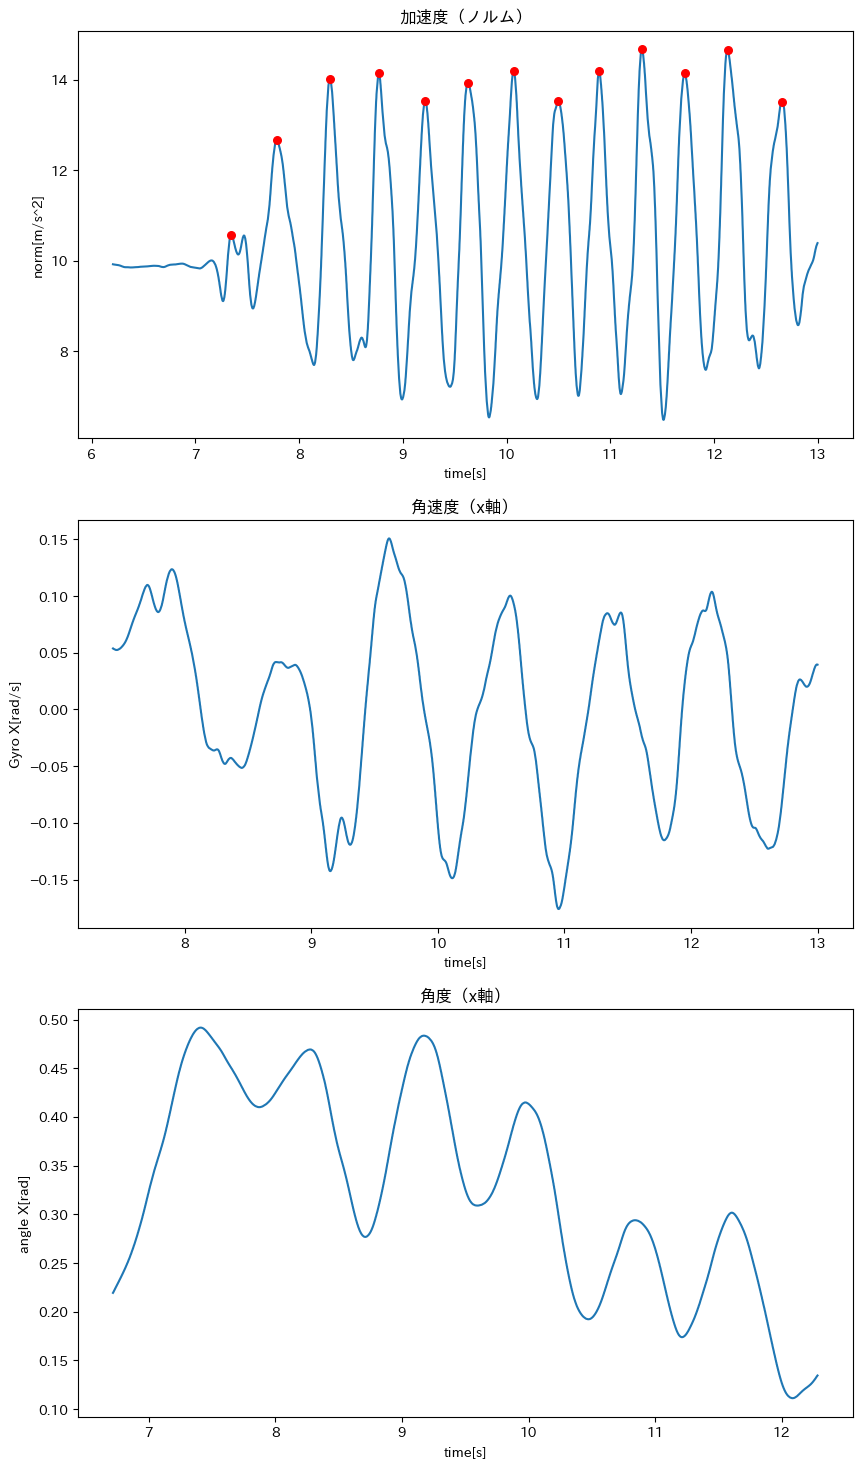

In [48]:
plt.subplots_adjust(hspace=0.3)
fig = plt.figure(figsize=(10, 18))

# 加速度（ノルム）のプロット
ax1 = fig.add_subplot(3,1,1)
ax1.plot(df_acc["t"], df_acc["low_norm"])
ax1.set_title("加速度（ノルム）")
ax1.set_xlabel("time[s]")
ax1.set_ylabel("norm[m/s^2]")

# ピークの検出とプロット
peek, _ = signal.find_peaks(df_acc['low_norm'], distance=100, height=10.5)
ax1.scatter(df_acc['t'][peek], df_acc['low_norm'][peek], s=30, color='red', zorder=2)

# 角速度（x軸）のプロット
ax2 = fig.add_subplot(3,1,2)
ax2.plot(df_gyro["t"], df_gyro["low_x"])
ax2.set_title("角速度（x軸）")
ax2.set_xlabel("time[s]")
ax2.set_ylabel("Gyro X[rad/s]")

# 角度（x軸）のプロット
ax3 = fig.add_subplot(3,1,3)
ax3.plot(df_gyro["t"], df_gyro["low_angle"])
ax3.set_title("角度（x軸）")
ax3.set_xlabel("time[s]")
ax3.set_ylabel("angle X[rad]")

plt.show()

# 軌跡の描画

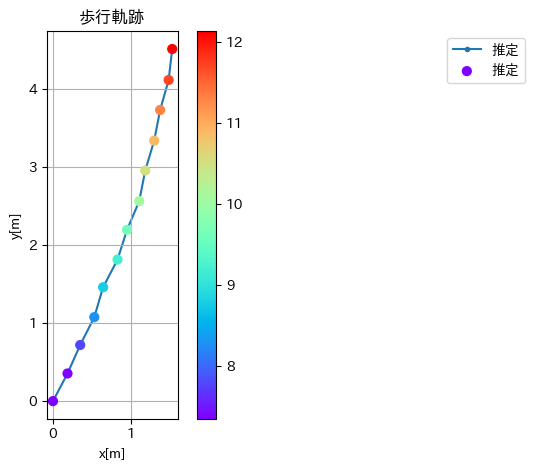

In [49]:
# 軌跡を描く
step = 0.4
point = [[0, 0]]
times = []

if len (peek) > 0:
    times.append(df_acc['t'][peek[0]]) 
    for p in peek:

        x = step * np.sin(df_gyro['low_angle'][p]*1) + point[-1][0]
        y = step * np.cos(df_gyro['low_angle'][p]*1) + point[-1][1]
            
        point.append([x, y])
        times.append(df_acc['t'][p])

else:
    times.append(0.0) 
    point.append([0, 0]) # 0秒の軌跡として原点を追加
    print("警告: ピークが検出されませんでした。初期位置 (0,0) と時刻 0.0 のみがプロットされます。")


point = pd.DataFrame(data=point, columns=['x', 'y'])
point['time'] = times
point['x'] = point['x'] - point['x'][0]
point['y'] = point['y'] - point['y'][0]

size = ((-1, 10), (-1, 10))

plt.plot(point['x'], point['y'], '.-', label='推定', zorder=1)
plt.colorbar(plt.scatter(point['x'], point['y'],c=point['time'],cmap='rainbow',s=40, label='推定', zorder=2))

# 原点を赤で描画
# plt.plot(0, 0, 'ro', label='原点', zorder=2)  # 'ro' は red + circle

# 軸を揃える
plt.gca().set_aspect('equal', adjustable='box')

plt.title('歩行軌跡')
plt.xlabel('x[m]')
plt.ylabel('y[m]')


plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(3.0, 1.0))  # グラフの右外側に表示
plt.tight_layout()
plt.show()

# 新しい一定間隔の時刻データを生成


--- 補間後の軌跡データ (先頭5行) ---
     time         x         y
0    0.00      -inf      -inf
1    0.25      -inf      -inf
2    0.50      -inf      -inf
3    0.75      -inf      -inf
4    1.00      -inf      -inf
5    1.25      -inf      -inf
6    1.50      -inf      -inf
7    1.75      -inf      -inf
8    2.00      -inf      -inf
9    2.25      -inf      -inf
10   2.50      -inf      -inf
11   2.75      -inf      -inf
12   3.00      -inf      -inf
13   3.25      -inf      -inf
14   3.50      -inf      -inf
15   3.75      -inf      -inf
16   4.00      -inf      -inf
17   4.25      -inf      -inf
18   4.50      -inf      -inf
19   4.75      -inf      -inf
20   5.00      -inf      -inf
21   5.25      -inf      -inf
22   5.50      -inf      -inf
23   5.75      -inf      -inf
24   6.00      -inf      -inf
25   6.25      -inf      -inf
26   6.50      -inf      -inf
27   6.75      -inf      -inf
28   7.00      -inf      -inf
29   7.25      -inf      -inf
30   7.50  0.243661  0.483523
31   7.75  0.3

/opt/homebrew/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


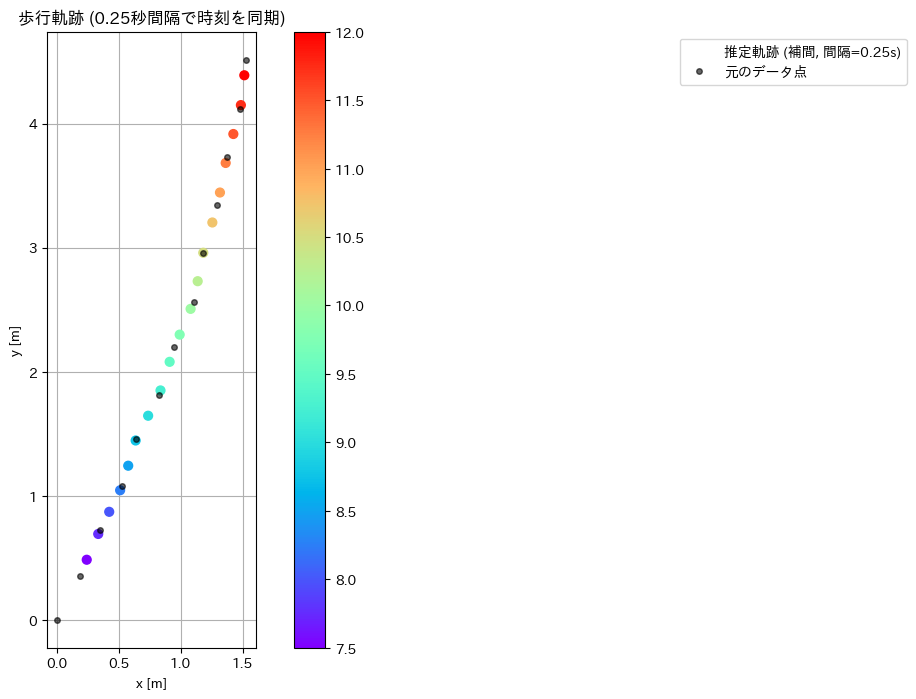

In [50]:
# サンプリング間隔の設定
sampling_interval = 0.25 # この値を調整してください


if len(point) < 2:
    print("エラー: 補間を行うには、最低2点以上の軌跡データが必要です。")
    print("ピーク検出のパラメータを調整するか、より多くのデータを提供してください。")
    exit()


# ピーク時の軌跡の時刻データの最小値と最大値を取得
min_time_resampled = 0.0
max_time_resampled = point['time'].max()

# 新しい一定間隔の時刻データを生成
resampled_times = np.arange(min_time_resampled, max_time_resampled + sampling_interval, sampling_interval)

# x, y 座標を新しい時刻に合わせて補正
# kind='linear' : 線形補間
# # fill_value="extrapolate" : 元のデータの範囲外でも補間
interp_x = interp1d(point['time'], point['x'], kind='linear', fill_value="extrapolate")
interp_y = interp1d(point['time'], point['y'], kind='linear', fill_value="extrapolate")

resampled_x = interp_x(resampled_times)
resampled_y = interp_y(resampled_times)



# 補間されたデータで新しいDataFrameを作成
# このresampled_pointが、timesを一定間隔で同期した軌跡データです。
resampled_point = pd.DataFrame({
    'time': resampled_times,
    'x': resampled_x,
    'y': resampled_y
})

print("\n--- 補間後の軌跡データ (先頭5行) ---")
print(resampled_point)

## CSVで出力
resampled_point.to_csv('resampled_point.csv', index=False)


print(f"\n補間後のデータ点数: {len(resampled_point)}")
print(f"補間後の時刻間隔: {resampled_point['time'].diff().mean():.6f} 秒 (平均)")

# --- 5. 描画 ---
plt.figure(figsize=(10, 8))

# 補間された軌跡を描画
# plt.plot(resampled_point['x'], resampled_point['y'], '.-', label=f'推定軌跡 (補間, 間隔={sampling_interval}s)', zorder=1, alpha=0.8)
plt.colorbar(plt.scatter(resampled_point['x'], resampled_point['y'],c=resampled_point['time'],cmap='rainbow',s=40, label=f'推定軌跡 (補間, 間隔={sampling_interval}s)', zorder=2))

# 元の不規則間隔の軌跡の点も重ねて表示（補間効果の確認用）
plt.plot(point['x'], point['y'], 'o', markersize=4, color='black', alpha=0.6, label='元のデータ点')

# 軸を揃える
plt.gca().set_aspect('equal', adjustable='box')

plt.title('歩行軌跡 (0.25秒間隔で時刻を同期)')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(3.0, 1.0))  # グラフの右外側に表示
plt.show()

## 余分なデータの削除

### x,y座標がinfの行を削除

In [51]:
# 'x' 列と 'y' 列が有限な値（inf, -inf, NaNではない）である行のみを保持
finite_condition = np.isfinite(resampled_point['x']) & np.isfinite(resampled_point['y'])
resampled_point = resampled_point[finite_condition].reset_index(drop=True)

## csvファイルの作成

In [52]:
# 5. CSVファイルへの保存
csv_file_name = 'walkingTrajectoryFastWalk.csv'
if not resampled_point.empty:
    try:
        resampled_point.to_csv(csv_file_name, index=False)
        print(f"'{csv_file_name}' が正常に作成されました。")
        print("DataFrameの内容 (最初の5行):")
        print(resampled_point.head())
    except Exception as e:
        print(f"CSVファイル保存中にエラーが発生しました: {e}")
else:
    print("保存する軌跡データがありません。")

'walkingTrajectoryFastWalk.csv' が正常に作成されました。
DataFrameの内容 (最初の5行):
   time         x         y
0  7.50  0.243661  0.483523
1  7.75  0.336345  0.691347
2  8.00  0.424955  0.869884
3  8.25  0.512928  1.043840
4  8.50  0.578099  1.241588
